In [107]:
import os
import numpy as np
import torch

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

%matplotlib inline

In [108]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    

CUDA is available!  Training on GPU ...


In [109]:
data_dir = 'humans/'
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')


classes = ['ali', 'badis', 'hmila', 'mootez', 'amine mah']

In [115]:
data_transform = transforms.Compose([transforms.RandomResizedCrop(224), 
                                      transforms.ToTensor()])

train_data = datasets.ImageFolder(train_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)


print('Num training images: ', len(train_data))
print('Num test images: ', len(test_data))

Num training images:  2950
Num test images:  118


In [116]:
batch_size = 20
num_workers=0


train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

<ipython-input-117-5597213d2066>:7: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])


IndexError: list index out of range

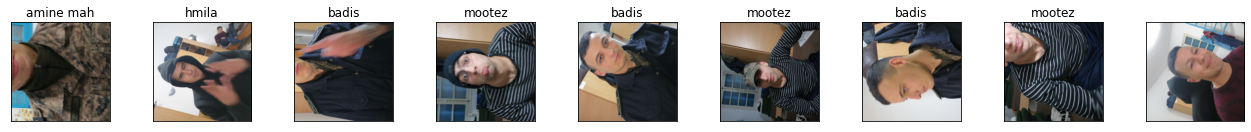

In [117]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() 

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [11]:
vgg16 = models.vgg16(pretrained=True)


In [12]:
print(vgg16.classifier[6].in_features) 
print(vgg16.classifier[6].out_features) 


4096
1000


In [13]:
for param in vgg16.features.parameters():
    param.requires_grad = False
    

In [36]:
import torch.nn as nn 
n_inputs = vgg16.classifier[6].in_features


In [37]:
last_layer = nn.Linear(n_inputs, len(classes))

vgg16.classifier[6] = last_layer


In [38]:
if train_on_gpu:
    vgg16.cuda()

In [39]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001)

In [18]:
n_epochs = 20

for epoch in range(1, n_epochs+1):

    train_loss = 0.0
    for batch_i, (data, target) in enumerate(train_loader):
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = vgg16(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        if batch_i % 20 == 19:   
            print('Epoch %d, Batch %d loss: %.16f' %
                  (epoch, batch_i + 1, train_loss / 20))
            train_loss = 0.0


Epoch 1, Batch 20 loss: 1.4841382563114167
Epoch 1, Batch 40 loss: 1.1913569450378418
Epoch 1, Batch 60 loss: 1.0196046501398086
Epoch 1, Batch 80 loss: 0.8615491807460784
Epoch 1, Batch 100 loss: 0.7620436787605286
Epoch 1, Batch 120 loss: 0.7161673337221146
Epoch 1, Batch 140 loss: 0.6285581111907959
Epoch 2, Batch 20 loss: 0.5965160727500916
Epoch 2, Batch 40 loss: 0.5322845742106438
Epoch 2, Batch 60 loss: 0.5021249875426292
Epoch 2, Batch 80 loss: 0.4612279117107391
Epoch 2, Batch 100 loss: 0.4518277779221535
Epoch 2, Batch 120 loss: 0.4434730648994446
Epoch 2, Batch 140 loss: 0.3811795487999916
Epoch 3, Batch 20 loss: 0.4235498622059822
Epoch 3, Batch 40 loss: 0.3618109598755836
Epoch 3, Batch 60 loss: 0.3927267223596573
Epoch 3, Batch 80 loss: 0.3561145558953285
Epoch 3, Batch 100 loss: 0.3385314740240574
Epoch 3, Batch 120 loss: 0.3030057646334171
Epoch 3, Batch 140 loss: 0.3680385790765285
Epoch 4, Batch 20 loss: 0.2914332032203674
Epoch 4, Batch 40 loss: 0.3068199798464775
Ep

In [124]:
test_loss = 0.0
class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))
vgg16.eval() 


for data, target in test_loader:
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    output = vgg16(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)    
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    for i in range(5):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1


test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(5):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))


Test Loss: 1.627736

Test Accuracy of   ali: 25% ( 1/ 4)
Test Accuracy of badis: 25% ( 2/ 8)
Test Accuracy of hmila:  0% ( 0/ 3)
Test Accuracy of mootez: 62% ( 5/ 8)
Test Accuracy of amine mah: 42% ( 3/ 7)
